In [2]:
import os
import random
import csv
from pathlib import Path

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import f1_score, confusion_matrix, classification_report, roc_curve, auc
from sklearn.preprocessing import label_binarize
from tqdm import tqdm
import seaborn as sns

# ========================== 1. CONFIG (LOCAL) ==========================
SEED = 42

# Device priority: MPS (Apple Silicon) -> CUDA -> CPU
if getattr(torch.backends, 'mps', None) is not None and torch.backends.mps.is_available():
    device = 'mps'
elif torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'
print('Device:', device)

# Project root = folder chứa repo (điều chỉnh nếu bạn chạy từ nơi khác)
PROJECT_ROOT = Path.cwd()
# Nếu bạn mở notebook từ folder Script/, Path.cwd() sẽ là repo root khi chạy trong VS Code (thường là vậy).
# Nếu không đúng, bạn có thể set cứng: PROJECT_ROOT = Path('/absolute/path/to/Skincancer_VIT_Ver1.0_121125')

BASE_DATA_DIR = PROJECT_ROOT / 'data'
TRAIN_DIR = BASE_DATA_DIR / 'Train'
TEST_DIR = BASE_DATA_DIR / 'Test'

assert TRAIN_DIR.exists(), f'Missing: {TRAIN_DIR}'
assert TEST_DIR.exists(), f'Missing: {TEST_DIR}'
print('Train dir:', TRAIN_DIR)
print('Test dir :', TEST_DIR)

NUM_CLASSES = 9
BATCH_SIZE = 32
NUM_EPOCHS = 50
LEARNING_RATE = 1e-4
WEIGHT_DECAY = 1e-4
T_MAX = 20
OVERSAMPLE_FACTOR = 5

# macOS thường ổn nhất với num_workers=0 (tránh lỗi fork/spawn khi debug).
NUM_WORKERS = 0
PIN_MEMORY = True if device == 'cuda' else False
PATIENCE = 6
USE_FOCAL = True

BASE_PATH = PROJECT_ROOT / 'outputs' / 'DenseNet121_Results'
LOG_DIR = BASE_PATH / 'logs'
CKPT_DIR = BASE_PATH / 'checkpoints'
BEST_DIR = BASE_PATH / 'best_model'
RESULT_DIR = BASE_PATH / 'results'

LOG_DIR.mkdir(parents=True, exist_ok=True)
CKPT_DIR.mkdir(parents=True, exist_ok=True)
BEST_DIR.mkdir(parents=True, exist_ok=True)
RESULT_DIR.mkdir(parents=True, exist_ok=True)

LOG_CSV = LOG_DIR / 'training_log.csv'

# Seed
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

# ========================== 2. LABEL MAP ==========================
label_map = {
    0: 'actinic keratosis',
    1: 'basal cell carcinoma',
    2: 'dermatofibroma',
    3: 'melanoma',
    4: 'nevus',
    5: 'pigmented benign keratosis',
    6: 'seborrheic keratosis',
    7: 'squamous cell carcinoma',
    8: 'vascular lesion'
}

Device: mps
Train dir: /Users/nguyenhuuthang/Documents/RepoGitHub/Skincancer_VIT_Ver1.0_121125/Script/data/Train
Test dir : /Users/nguyenhuuthang/Documents/RepoGitHub/Skincancer_VIT_Ver1.0_121125/Script/data/Test


In [3]:
# ========================== 3. RAW DATASET ==========================
train_dataset_raw = datasets.ImageFolder(str(TRAIN_DIR))
test_dataset = datasets.ImageFolder(str(TEST_DIR))

print('Train samples:', len(train_dataset_raw))
print('Test  samples:', len(test_dataset))
print('Class folders (ImageFolder):', train_dataset_raw.classes)

# ========================== 4. TRANSFORMS / AUGMENT ==========================
class RandomAugmentationPerImage:
    def __init__(self):
        self.augmentations = [
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.RandomVerticalFlip(p=0.5),
            transforms.RandomRotation(40),
            transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
        ]
        self.resize = transforms.Resize((224, 224))
        self.to_tensor = transforms.ToTensor()
        self.normalize = transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

    def __call__(self, img):
        img = self.resize(img)
        for aug in self.augmentations:
            if torch.rand(1) < 0.5:
                img = aug(img)
        img = self.to_tensor(img)
        img = self.normalize(img)
        return img

transform_train = RandomAugmentationPerImage()
transform_val = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])

Train samples: 2239
Test  samples: 118
Class folders (ImageFolder): ['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


--- Original Train Distribution ---
0 (actinic keratosis): 114 samples | 5.09%
1 (basal cell carcinoma): 376 samples | 16.79%
2 (dermatofibroma): 95 samples | 4.24%
3 (melanoma): 438 samples | 19.56%
4 (nevus): 357 samples | 15.94%
5 (pigmented benign keratosis): 462 samples | 20.63%
6 (seborrheic keratosis): 77 samples | 3.44%
7 (squamous cell carcinoma): 181 samples | 8.08%
8 (vascular lesion): 139 samples | 6.21%


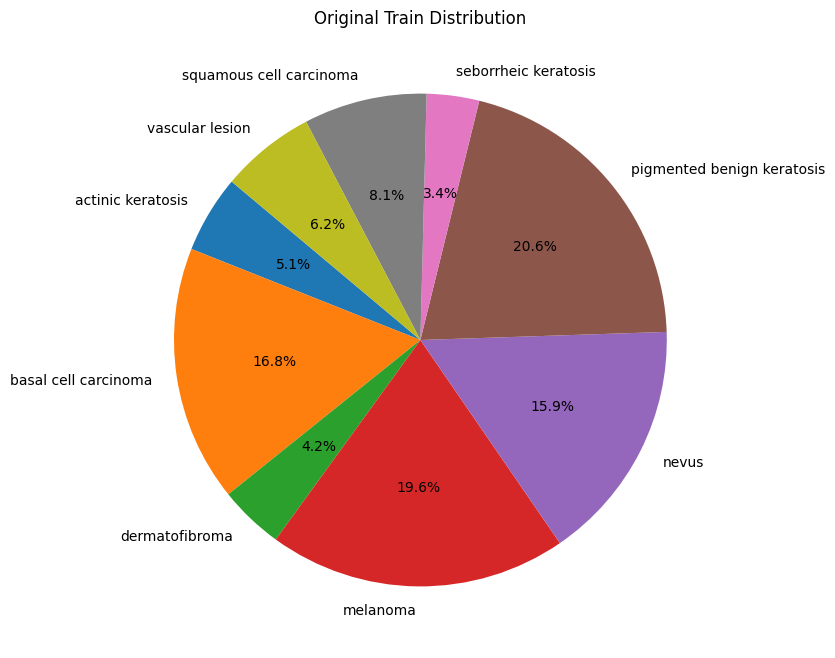

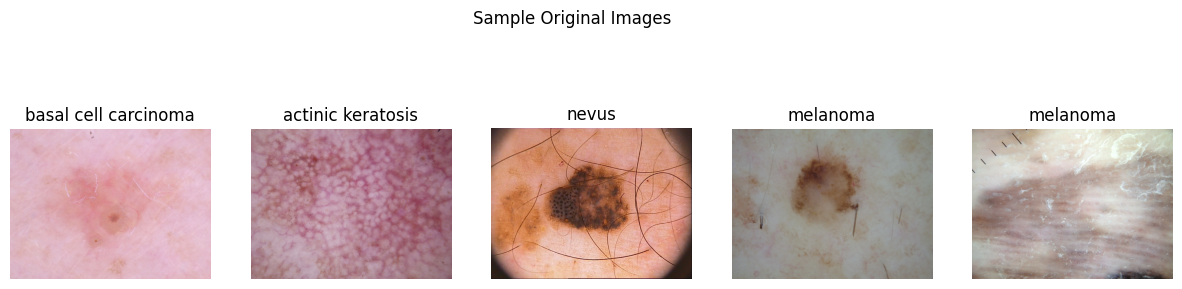

In [4]:
# ========================== 5. PLOT SAMPLE & CLASS DISTRIBUTION ==========================
def plot_class_distribution(labels, label_map, title='Class Distribution'):
    counter = Counter(labels)
    total = sum(counter.values())
    print(f'--- {title} ---')
    for i in range(len(label_map)):
        count = counter.get(i, 0)
        print(f'{i} ({label_map[i]}): {count} samples | {count / total * 100:.2f}%')
    counts = [counter.get(i, 0) for i in range(len(label_map))]
    plt.figure(figsize=(8, 8))
    plt.pie(counts, labels=[label_map[i] for i in range(len(label_map))], autopct='%1.1f%%', startangle=140)
    plt.title(title)
    plt.show()

# Original distribution
original_labels = [label for _, label in train_dataset_raw.imgs]
plot_class_distribution(original_labels, label_map, title='Original Train Distribution')

# Show 5 random images before augmentation
fig, axes = plt.subplots(1, 5, figsize=(15, 4))
for i, ax in enumerate(axes):
    img, label = train_dataset_raw[random.randint(0, len(train_dataset_raw) - 1)]
    ax.imshow(img)
    ax.set_title(label_map[label])
    ax.axis('off')
plt.suptitle('Sample Original Images')
plt.show()

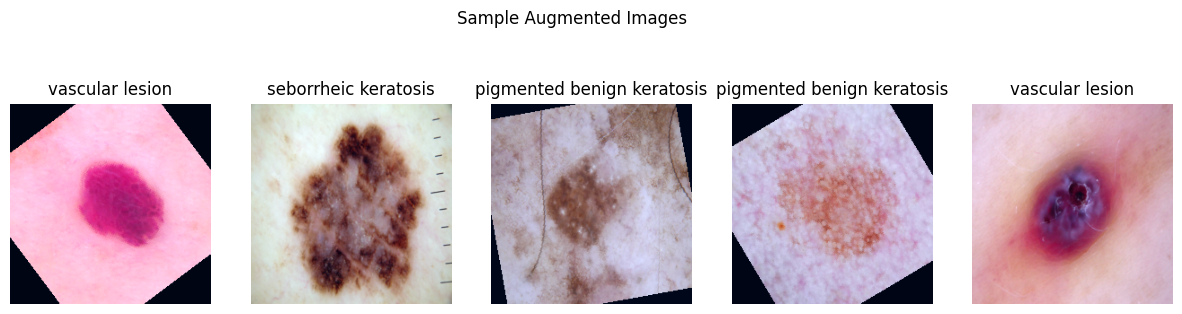

In [5]:
# ========================== 6. OVERSAMPLING ==========================
targets = [train_dataset_raw.imgs[i][1] for i in range(len(train_dataset_raw.imgs))]
class_counts = Counter(targets)
max_count = max(class_counts.values()) * OVERSAMPLE_FACTOR
weights_per_class = {cls: max_count / count for cls, count in class_counts.items()}
sample_weights = np.array([weights_per_class[t] for t in targets])
indices = np.random.choice(
    len(targets),
    size=len(targets) * OVERSAMPLE_FACTOR,
    replace=True,
    p=sample_weights / sample_weights.sum(),
)

class OversampledDataset(Dataset):
    def __init__(self, base_dataset, indices, transform=None):
        self.base_dataset = base_dataset
        self.indices = indices
        self.transform = transform

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        img, label = self.base_dataset[self.indices[idx]]
        if self.transform:
            img = self.transform(img)
        return img, label

train_dataset_full = OversampledDataset(train_dataset_raw, indices, transform=transform_train)

# Show 5 augmented images
fig, axes = plt.subplots(1, 5, figsize=(15, 4))
for i, ax in enumerate(axes):
    img, label = train_dataset_full[random.randint(0, len(train_dataset_full) - 1)]
    img_np = img.permute(1, 2, 0).numpy()
    denom = (img_np.max() - img_np.min())
    img_np = (img_np - img_np.min()) / (denom if denom != 0 else 1.0)
    ax.imshow(img_np)
    ax.set_title(label_map[label])
    ax.axis('off')
plt.suptitle('Sample Augmented Images')
plt.show()

--- Train Distribution After Oversampling ---
0 (actinic keratosis): 891 samples | 11.37%
1 (basal cell carcinoma): 867 samples | 11.06%
2 (dermatofibroma): 869 samples | 11.09%
3 (melanoma): 895 samples | 11.42%
4 (nevus): 890 samples | 11.36%
5 (pigmented benign keratosis): 871 samples | 11.12%
6 (seborrheic keratosis): 855 samples | 10.91%
7 (squamous cell carcinoma): 850 samples | 10.85%
8 (vascular lesion): 848 samples | 10.82%


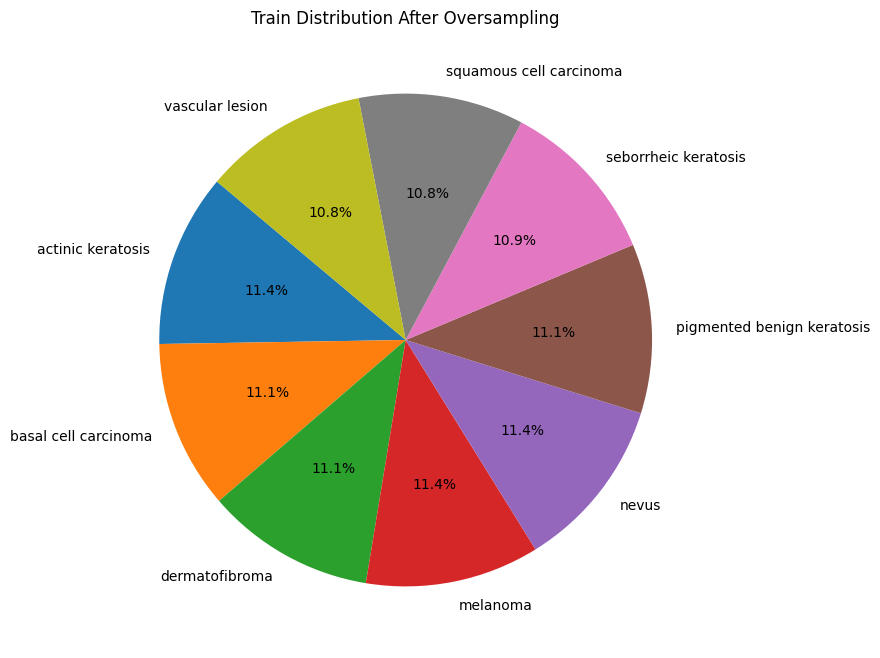

In [6]:
# ========================== 7. SPLIT TRAIN / VAL ==========================
oversampled_imgs = [train_dataset_raw.imgs[i] for i in indices]
paths, labels = zip(*oversampled_imgs)
paths = np.array(paths)
labels = np.array(labels)

train_paths, val_paths, train_labels, val_labels = train_test_split(
    paths, labels, test_size=0.3, stratify=labels, random_state=SEED
)

class CustomDataset(Dataset):
    def __init__(self, paths, labels, transform=None):
        self.paths = np.array(paths)
        self.labels = np.array(labels)
        self.transform = transform

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        img = Image.open(self.paths[idx]).convert('RGB')
        label = int(self.labels[idx])
        if self.transform:
            img = self.transform(img)
        return img, label

train_loader = DataLoader(
    CustomDataset(train_paths, train_labels, transform=transform_train),
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS,
    pin_memory=PIN_MEMORY,
)

val_loader = DataLoader(
    CustomDataset(val_paths, val_labels, transform=transform_val),
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=PIN_MEMORY,
)

test_paths = [p for p, _ in test_dataset.imgs]
test_labels = [l for _, l in test_dataset.imgs]
test_loader = DataLoader(
    CustomDataset(test_paths, test_labels, transform=transform_val),
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=PIN_MEMORY,
)

plot_class_distribution(train_labels, label_map, title='Train Distribution After Oversampling')

In [7]:
# ========================== 8. CLASS WEIGHTS & LOSS ==========================
train_labels_for_weights = train_labels.astype(int)
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_labels_for_weights),
    y=train_labels_for_weights,
)
class_weights = torch.tensor(class_weights, dtype=torch.float32).to(device)

class FocalLoss(nn.Module):
    def __init__(self, gamma=2, weight=None, reduction='mean'):
        super().__init__()
        self.gamma = gamma
        self.weight = weight
        self.reduction = reduction

    def forward(self, inputs, targets):
        ce = nn.CrossEntropyLoss(weight=self.weight, reduction='none')(inputs, targets)
        pt = torch.exp(-ce)
        loss = ((1 - pt) ** self.gamma) * ce
        if self.reduction == 'mean':
            return loss.mean()
        elif self.reduction == 'sum':
            return loss.sum()
        else:
            return loss

criterion = FocalLoss(gamma=2.0, weight=class_weights) if USE_FOCAL else nn.CrossEntropyLoss(weight=class_weights)

# ========================== 9. EARLY STOPPING ==========================
class EarlyStopping:
    def __init__(self, patience=5, delta=0.0):
        self.patience = patience
        self.delta = delta
        self.best_f1 = None
        self.counter = 0
        self.early_stop = False

    def __call__(self, f1):
        if self.best_f1 is None:
            self.best_f1 = f1
            return
        if f1 < self.best_f1 + self.delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_f1 = f1
            self.counter = 0

In [8]:
# ========================== 10. DENSENET121 MODEL ==========================
class DenseNet121Model(nn.Module):
    def __init__(self, num_classes=NUM_CLASSES, pretrained=True):
        super().__init__()
        # Torchvision API compatibility: pretrained=... (old) vs weights=... (new)
        if pretrained:
            try:
                weights = models.DenseNet121_Weights.DEFAULT
                self.densenet = models.densenet121(weights=weights)
            except Exception:
                self.densenet = models.densenet121(pretrained=True)
        else:
            try:
                self.densenet = models.densenet121(weights=None)
            except Exception:
                self.densenet = models.densenet121(pretrained=False)

        # Freeze early layers
        for i, child in enumerate(self.densenet.features.children()):
            if i < 6:
                for param in child.parameters():
                    param.requires_grad = False

        # Replace classifier
        num_features = self.densenet.classifier.in_features
        self.densenet.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(num_features, 512),
            nn.ReLU(),
            nn.BatchNorm1d(512),
            nn.Dropout(0.3),
            nn.Linear(512, num_classes),
        )

    def forward(self, x):
        return self.densenet(x)

model = DenseNet121Model(num_classes=NUM_CLASSES).to(device)
print(f'Model loaded on {device}')
print(f'Total parameters: {sum(p.numel() for p in model.parameters())}')
print(f'Trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad)}')

Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /Users/nguyenhuuthang/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 54.7MB/s]


Model loaded on mps
Total parameters: 7484297
Trainable parameters: 7106441


In [9]:
# ========================== 11. TRAIN / EVAL FUNCTIONS ==========================
def train_one_epoch(model, loader, optimizer, criterion, device, epoch):
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    loop = tqdm(enumerate(loader), total=len(loader), desc=f'Epoch {epoch} [TRAIN]')
    for i, (imgs, labels) in loop:
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        preds = outputs.argmax(1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
        loop.set_postfix(loss=running_loss / (i + 1), acc=correct / total)
    return running_loss / len(loader), correct / total

def eval_one_epoch(model, loader, criterion, device, epoch):
    model.eval()
    running_loss, correct, total = 0.0, 0, 0
    all_preds, all_labels = [], []
    with torch.no_grad():
        loop = tqdm(enumerate(loader), total=len(loader), desc=f'Epoch {epoch} [VAL]')
        for i, (imgs, labels) in loop:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            preds = outputs.argmax(1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            correct += (preds == labels).sum().item()
            total += labels.size(0)
            loop.set_postfix(loss=running_loss / (i + 1), acc=correct / total)
    macro_f1 = f1_score(all_labels, all_preds, average='macro')
    return running_loss / len(loader), correct / total, macro_f1

In [10]:
# ========================== 12. TRAINING LOOP ==========================
optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=T_MAX)
early_stopper = EarlyStopping(patience=PATIENCE)

best_f1 = 0.0
best_epoch = 0
history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': [], 'f1': []}

with open(LOG_CSV, 'w', newline='') as f:
    writer = csv.writer(f)
    writer.writerow(['epoch', 'train_loss', 'train_acc', 'val_loss', 'val_acc', 'macro_f1'])

for epoch in range(1, NUM_EPOCHS + 1):
    train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, criterion, device, epoch)
    val_loss, val_acc, val_macro_f1 = eval_one_epoch(model, val_loader, criterion, device, epoch)

    scheduler.step()
    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)
    history['train_acc'].append(train_acc)
    history['val_acc'].append(val_acc)
    history['f1'].append(val_macro_f1)

    with open(LOG_CSV, 'a', newline='') as f:
        writer = csv.writer(f)
        writer.writerow([epoch, train_loss, train_acc, val_loss, val_acc, val_macro_f1])

    if epoch % 10 == 0:
        ckpt_path = CKPT_DIR / f'model_epoch_{epoch}.pt'
        torch.save(model.state_dict(), ckpt_path)
        print(' Saved checkpoint:', ckpt_path)

    if val_macro_f1 > best_f1:
        best_f1 = val_macro_f1
        best_epoch = epoch
        best_path = BEST_DIR / 'best_model_densenet121.pt'
        torch.save(model.state_dict(), best_path)
        print(f' Best model updated at epoch {epoch} | F1={best_f1:.4f}')

    print(
        f'Epoch {epoch}/{NUM_EPOCHS} | Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | '
        f'Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f} | Macro F1: {val_macro_f1:.4f}'
    )

    early_stopper(val_macro_f1)
    if early_stopper.early_stop:
        print('>>> Early stopping triggered. Stopping training.')
        break

print('\nTraining completed. Best Epoch =', best_epoch, '| Best F1 =', best_f1)

Epoch 1 [VAL]: 100%|██████████| 105/105 [02:21<00:00,  1.34s/it, acc=0.735, loss=0.402]


 Best model updated at epoch 1 | F1=0.7330
Epoch 1/50 | Train Loss: 1.0837 | Train Acc: 0.4455 | Val Loss: 0.4023 | Val Acc: 0.7347 | Macro F1: 0.7330


Epoch 2 [VAL]: 100%|██████████| 105/105 [01:36<00:00,  1.09it/s, acc=0.839, loss=0.212]


 Best model updated at epoch 2 | F1=0.8330
Epoch 2/50 | Train Loss: 0.4856 | Train Acc: 0.6793 | Val Loss: 0.2124 | Val Acc: 0.8389 | Macro F1: 0.8330


Epoch 3 [VAL]: 100%|██████████| 105/105 [01:25<00:00,  1.23it/s, acc=0.865, loss=0.139]


 Best model updated at epoch 3 | F1=0.8645
Epoch 3/50 | Train Loss: 0.3167 | Train Acc: 0.7619 | Val Loss: 0.1393 | Val Acc: 0.8648 | Macro F1: 0.8645


Epoch 4 [VAL]: 100%|██████████| 105/105 [01:32<00:00,  1.13it/s, acc=0.902, loss=0.0966]


 Best model updated at epoch 4 | F1=0.8997
Epoch 4/50 | Train Loss: 0.2508 | Train Acc: 0.7968 | Val Loss: 0.0966 | Val Acc: 0.9018 | Macro F1: 0.8997


Epoch 5 [VAL]: 100%|██████████| 105/105 [01:32<00:00,  1.14it/s, acc=0.908, loss=0.0844]


 Best model updated at epoch 5 | F1=0.9074
Epoch 5/50 | Train Loss: 0.1966 | Train Acc: 0.8231 | Val Loss: 0.0844 | Val Acc: 0.9080 | Macro F1: 0.9074


Epoch 6 [VAL]: 100%|██████████| 105/105 [01:29<00:00,  1.17it/s, acc=0.926, loss=0.0761]


 Best model updated at epoch 6 | F1=0.9254
Epoch 6/50 | Train Loss: 0.1578 | Train Acc: 0.8485 | Val Loss: 0.0761 | Val Acc: 0.9262 | Macro F1: 0.9254


Epoch 7 [VAL]: 100%|██████████| 105/105 [01:33<00:00,  1.12it/s, acc=0.926, loss=0.0668]


Epoch 7/50 | Train Loss: 0.1462 | Train Acc: 0.8581 | Val Loss: 0.0668 | Val Acc: 0.9262 | Macro F1: 0.9253


Epoch 8 [VAL]: 100%|██████████| 105/105 [01:31<00:00,  1.14it/s, acc=0.929, loss=0.0718]


 Best model updated at epoch 8 | F1=0.9287
Epoch 8/50 | Train Loss: 0.1257 | Train Acc: 0.8709 | Val Loss: 0.0718 | Val Acc: 0.9294 | Macro F1: 0.9287


Epoch 9 [TRAIN]:  22%|██▏       | 55/245 [01:47<06:11,  1.96s/it, acc=0.886, loss=0.102] 


KeyboardInterrupt: 

Saved: /Users/nguyenhuuthang/Documents/RepoGitHub/Skincancer_VIT_Ver1.0_121125/Script/outputs/DenseNet121_Results/results/training_curves_densenet121.png


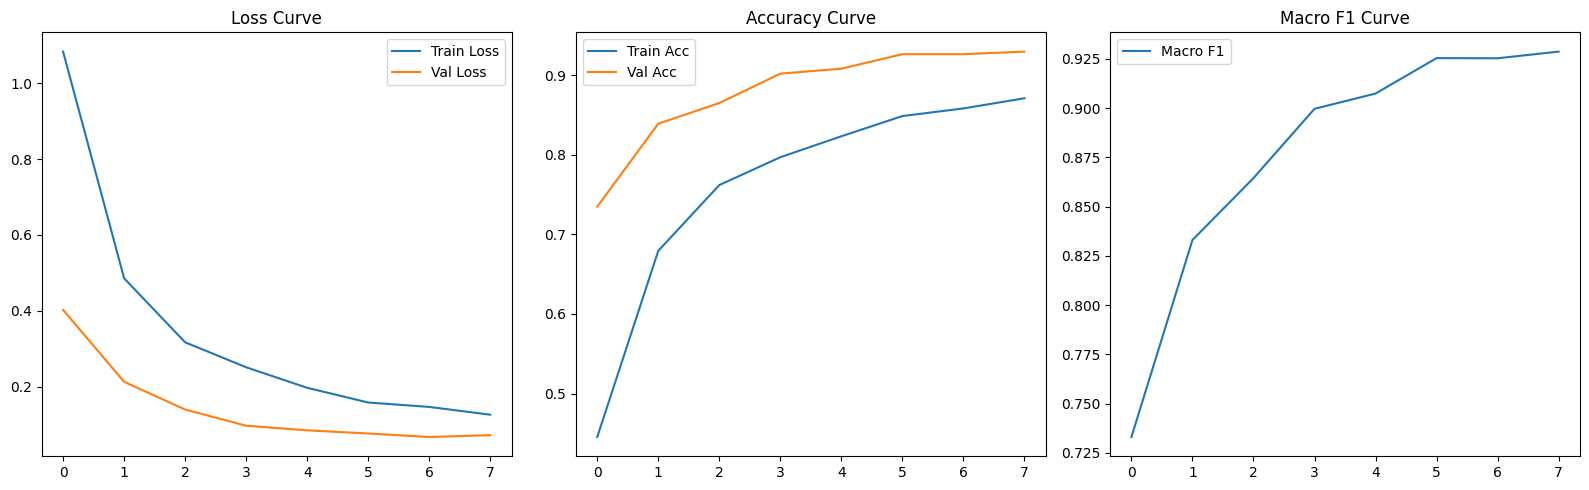

In [11]:
# ========================== 13. PLOT METRICS ==========================
plt.figure(figsize=(16, 5))
plt.subplot(1, 3, 1)
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Val Loss')
plt.title('Loss Curve')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(history['train_acc'], label='Train Acc')
plt.plot(history['val_acc'], label='Val Acc')
plt.title('Accuracy Curve')
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(history['f1'], label='Macro F1')
plt.title('Macro F1 Curve')
plt.legend()

plt.tight_layout()
plot_path = RESULT_DIR / 'training_curves_densenet121.png'
plt.savefig(plot_path)
print('Saved:', plot_path)
plt.show()

Loaded best model from /Users/nguyenhuuthang/Documents/RepoGitHub/Skincancer_VIT_Ver1.0_121125/Script/outputs/DenseNet121_Results/best_model/best_model_densenet121.pt
Saved: /Users/nguyenhuuthang/Documents/RepoGitHub/Skincancer_VIT_Ver1.0_121125/Script/outputs/DenseNet121_Results/results/val_conf_matrix_densenet121.png


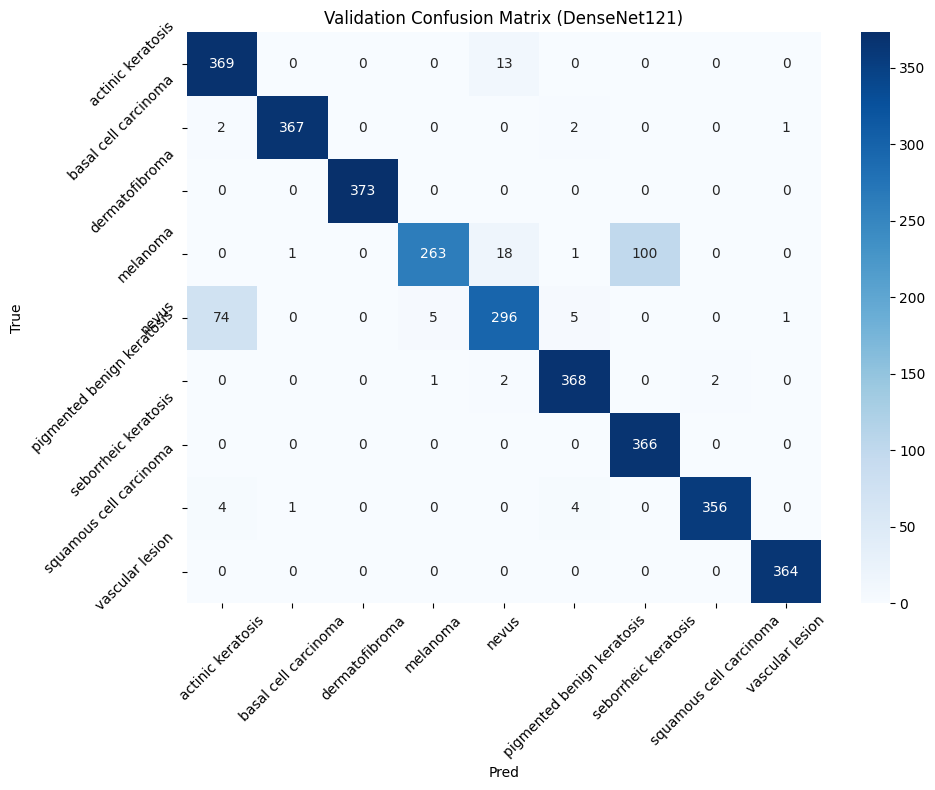

Saved: /Users/nguyenhuuthang/Documents/RepoGitHub/Skincancer_VIT_Ver1.0_121125/Script/outputs/DenseNet121_Results/results/test_conf_matrix_densenet121.png


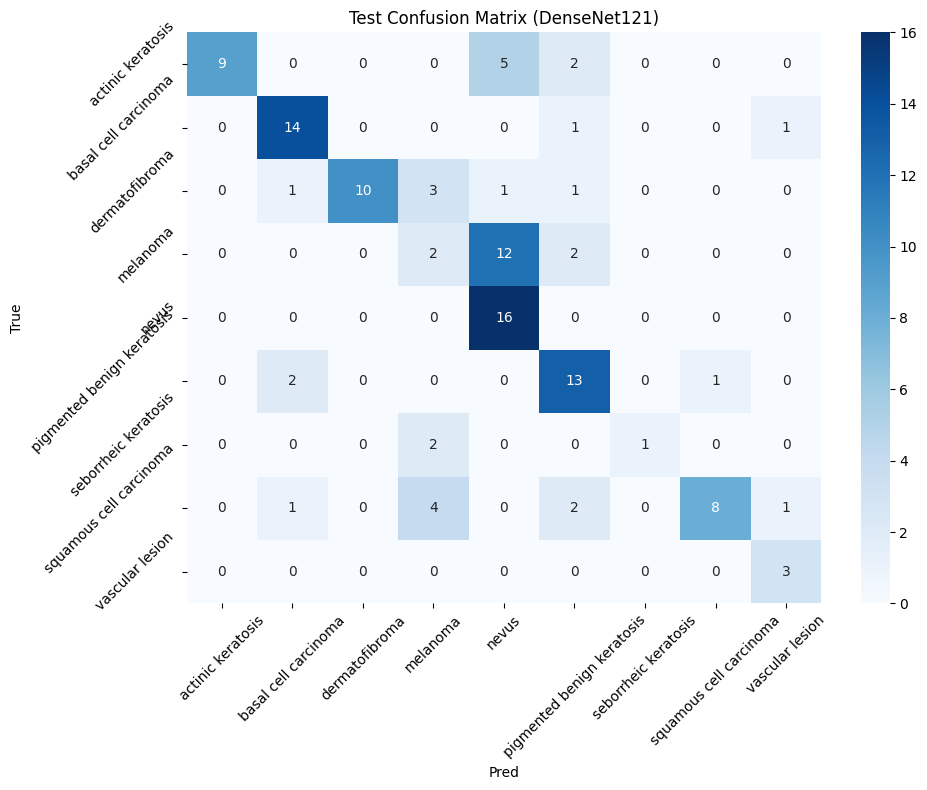

In [12]:
# ========================== 14. CONFUSION MATRIX & TEST ==========================
best_model_path = BEST_DIR / 'best_model_densenet121.pt'
if best_model_path.exists():
    model.load_state_dict(torch.load(best_model_path, map_location=device))
    print('Loaded best model from', best_model_path)
else:
    print('Best model not found yet at:', best_model_path)

def plot_confusion(loader, title, save_path):
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for imgs, labels in loader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            preds = outputs.argmax(1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=label_map.values(), yticklabels=label_map.values(), cmap='Blues')
    plt.title(title)
    plt.ylabel('True')
    plt.xlabel('Pred')
    plt.xticks(rotation=45)
    plt.yticks(rotation=45)
    plt.tight_layout()
    plt.savefig(save_path)
    print('Saved:', save_path)
    plt.show()

plot_confusion(val_loader, 'Validation Confusion Matrix (DenseNet121)', RESULT_DIR / 'val_conf_matrix_densenet121.png')
plot_confusion(test_loader, 'Test Confusion Matrix (DenseNet121)', RESULT_DIR / 'test_conf_matrix_densenet121.png')


Classification Report (DenseNet121):
                             precision    recall  f1-score   support

         actinic keratosis       0.82      0.97      0.89       382
      basal cell carcinoma       0.99      0.99      0.99       372
            dermatofibroma       1.00      1.00      1.00       373
                  melanoma       0.98      0.69      0.81       383
                     nevus       0.90      0.78      0.83       381
pigmented benign keratosis       0.97      0.99      0.98       373
      seborrheic keratosis       0.79      1.00      0.88       366
   squamous cell carcinoma       0.99      0.98      0.98       365
           vascular lesion       0.99      1.00      1.00       364

                  accuracy                           0.93      3359
                 macro avg       0.94      0.93      0.93      3359
              weighted avg       0.94      0.93      0.93      3359



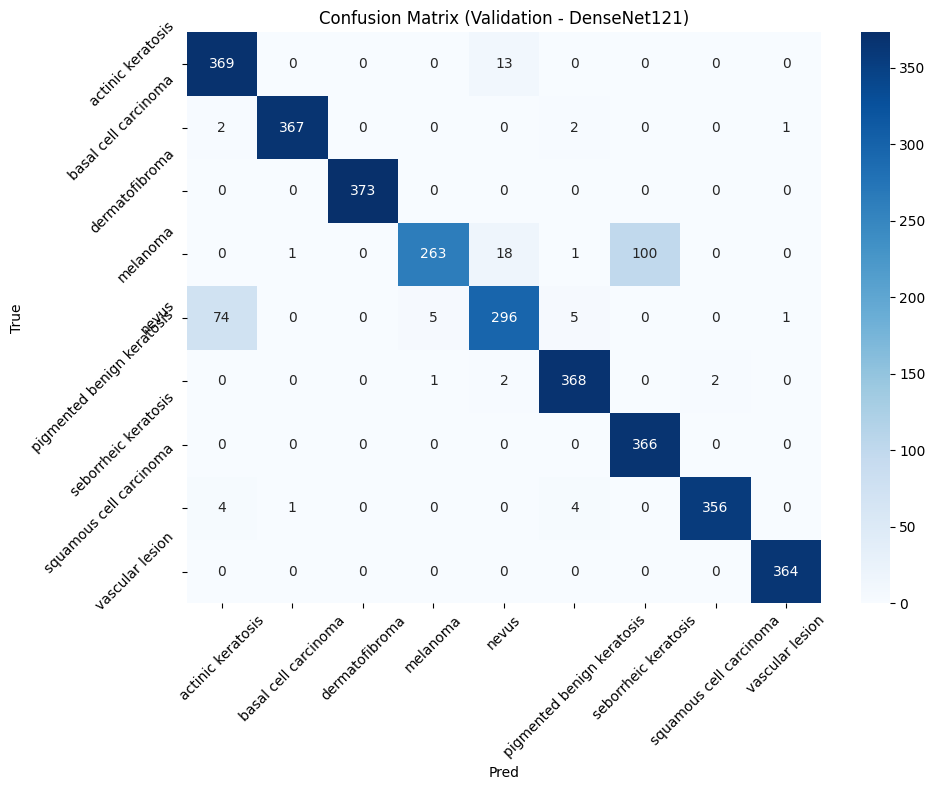


Number of samples per class in validation set:
actinic keratosis: 382
basal cell carcinoma: 372
dermatofibroma: 373
melanoma: 383
nevus: 381
pigmented benign keratosis: 373
seborrheic keratosis: 366
squamous cell carcinoma: 365
vascular lesion: 364


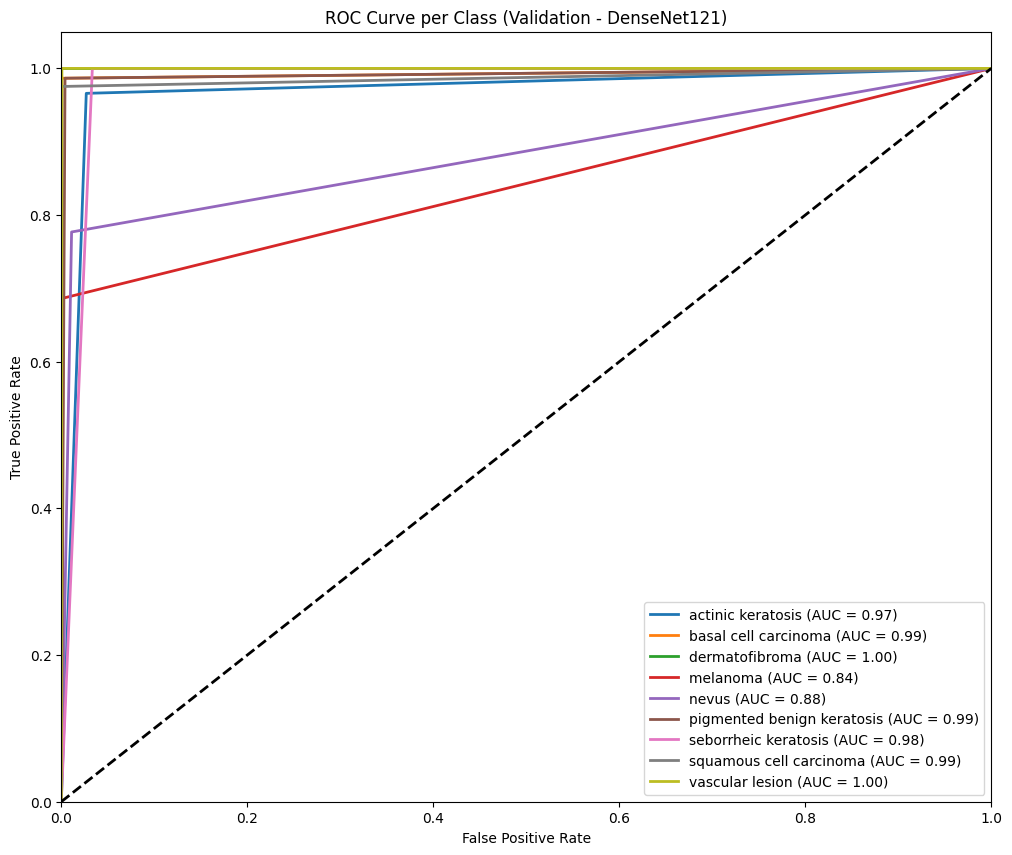

In [13]:
# ========================== 15. DETAILED EVALUATION ==========================
model.eval()
all_preds, all_labels = [], []
with torch.no_grad():
    for imgs, labels in val_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        outputs = model(imgs)
        preds = outputs.argmax(1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

all_labels = np.array(all_labels)
all_preds = np.array(all_preds)

report = classification_report(all_labels, all_preds, target_names=list(label_map.values()))
print('\nClassification Report (DenseNet121):\n', report)

cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=label_map.values(), yticklabels=label_map.values(), cmap='Blues')
plt.title('Confusion Matrix (Validation - DenseNet121)')
plt.ylabel('True')
plt.xlabel('Pred')
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.tight_layout()
plt.show()

counter = Counter(all_labels)
print('\nNumber of samples per class in validation set:')
for i, name in label_map.items():
    print(f'{name}: {counter[i]}')

# ROC & AUC per class (giữ nguyên cách tính như notebook gốc)
y_test_bin = label_binarize(all_labels, classes=list(range(NUM_CLASSES)))
y_score_bin = label_binarize(all_preds, classes=list(range(NUM_CLASSES)))

plt.figure(figsize=(12, 10))
for i in range(NUM_CLASSES):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_score_bin[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'{label_map[i]} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve per Class (Validation - DenseNet121)')
plt.legend(loc='lower right')
plt.show()